This Jupyter notebook implements [Dr. Toru Miyama](http://iprc.soest.hawaii.edu/people/miyama.php)'s Python code for univariate Wavelet analysis. 

The following is inspired from his IPython notebook available at:

https://github.com/tmiyama/WaveletAnalysis/blob/main/wavelet_test_ElNino3_Liu.ipynb

See also:

https://github.com/tmiyama/WaveletAnalysis/blob/main/wavelet_test_sine.ipynb 

References: 

- Liu, Y., X.S. Liang, and R.H. Weisberg, 2007: Rectification of the bias in the wavelet power spectrum. Journal of Atmospheric and Oceanic Technology, 24(12), 2093-2102. http://ocgweb.marine.usf.edu/~liu/wavelet.html

- Torrence, C., and G. P. Compo, 1998: A practical guide to wavelet analysis. Bull. Amer. Meteor. Soc., 79, 61–78. http://paos.colorado.edu/research/wavelets/

<!-- TEASER_END -->

### imports 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np 
from matplotlib import pyplot as plt

### load the `wavelib` module 

In [3]:
import sys

In [4]:
sys.path.append('.')

In [5]:
from wavelib import *

### loads the data 

In [6]:
data = np.loadtxt('/home/nicolasf/data/sst_nino3.dat')

In [7]:
data.shape

(504,)

In [8]:
N = data.size

### set up some parameters 

In [9]:
t0=1871
dt=0.25
units='^{\circ}C'
label='NINO3 SST'

In [10]:
time = np.arange(0, N) * dt + t0

### plot the raw time-series 

(1870.0, 2000.0)

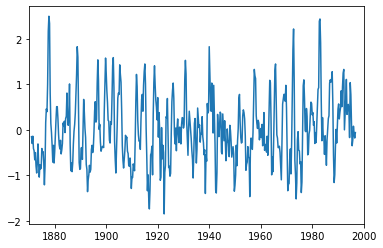

In [11]:
f, ax = plt.subplots()
ax.plot(time,data)
xlim = [1870,2000]  # plotting range
ax.set_xlim(xlim)

### calculate variance, mean and standardize the time-series 

In [12]:
variance = np.std(data)**2
mean=np.mean(data)
data = (data - np.mean(data))/np.sqrt(variance)
print("mean=",mean)
print("std=", np.sqrt(variance))

mean= -1.984126984127118e-05
std= 0.7335991128242201


### set wavelet parameters

In [13]:
pad = 1      # pad the time series with zeroes (recommended)
dj = 0.25    # this will do 4 sub-octaves per octave
s0 = 2.*dt    # this says start at a scale of 6 months
j1 = 7./dj    # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'Morlet'

### wavelet transform

In [14]:
wave,period,scale,coi = wavelet(data,dt,pad,dj,s0,j1,mother);
power = (np.abs(wave))**2         # compute wavelet power spectrum

### significance levels 

In [15]:
signif,fft_theor = wave_signif(1.0,dt,scale,0,lag1,-1,-1,mother)

In [16]:
sig95 = np.dot(signif.reshape(len(signif),1),np.ones((1,N))) # expand signif --> (J+1)x(N) array

In [17]:
sig95 = power / sig95         # where ratio > 1, power is significant

In [18]:
global_ws = variance*power.sum(axis=1)/float(N)   # time-average over all times

In [19]:
dof = N - scale  # the -scale corrects for padding at edges

In [20]:
global_signif,fft_theor = wave_signif(variance,dt,scale,1,lag1,-1,dof,mother)

### scale-average between 2 and 8 years

In [21]:
avg = (scale >= 2) & (scale < 8)
Cdelta = 0.776;   # this is for the MORLET wavelet
scale_avg = np.dot(scale.reshape(len(scale),1),np.ones((1,N))) # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg   # [Eqn(24)]
scale_avg = variance*dj*dt/Cdelta*sum(scale_avg[avg,:])   # [Eqn(24)]
scaleavg_signif ,fft_theor= wave_signif(variance,dt,scale,2,lag1,-1,[2,7.9],mother)

In [22]:
iwave=wavelet_inverse(wave, scale, dt, dj, "Morlet")
print("root square mean error",np.sqrt(np.sum((data-iwave)**2)/float(len(data)))*np.sqrt(variance),"deg C")

root square mean error 0.07755811016771955 deg C


### Bias rectification

divides by scales

In [23]:
########################
#  Spectrum
########################
powers=np.zeros_like(power)
for k in range(len(scale)):
    powers[k,:] = power[k,:]/scale[k]
#significance: sig95 is already normalized = 1

########################
#  Spectrum
########################
global_wss = global_ws/scale   
global_signifs=global_signif/scale

########################
#  Scale-average between El Nino periods of 2--8 years
########################
# No need to change 
# because in Eqn(24) of Torrence and Compo [1998], division by scale has been done.
scale_avgs=scale_avg
scaleavg_signifs=scaleavg_signif

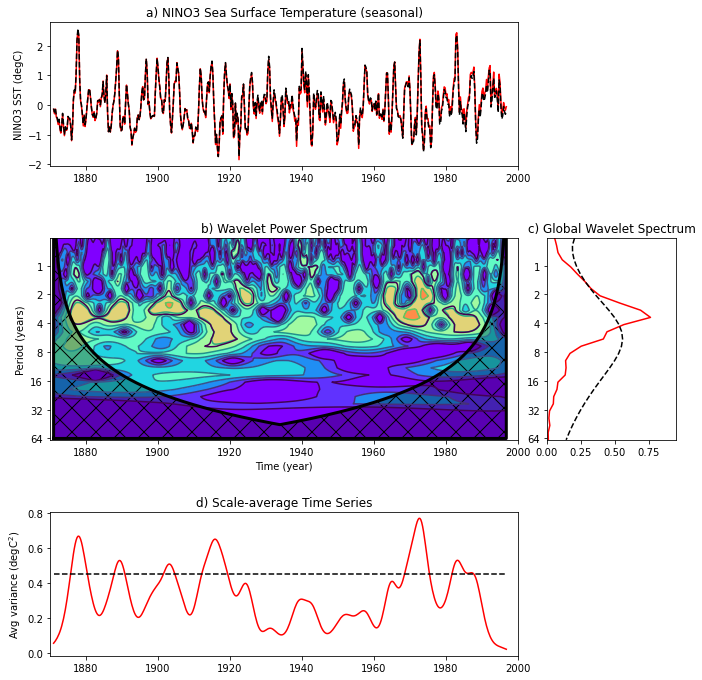

In [26]:


#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.37, width, hight]
pos1c = [0.79, 0.37, 0.18, hight]
pos1d = [0.1,  0.07, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,data*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('NINO3 SST (degC)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(int(np.log2(np.min(period))),int(np.log2(np.max(period)))+1))
bx.contour(time,np.log2(period),np.log2(powers),np.log2(levels))
bx.contourf(time,np.log2(period),np.log2(powers),np.log2(levels), extend='both', cmap=plt.get_cmap('rainbow'))
bx.set_xlabel('Time (year)')
bx.set_ylabel('Period (years)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1])

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_wss,np.log2(period),"r-")
cx.plot(global_signifs,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_wss)])

#########################################
#   d) Global Wavelet spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avgs,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signifs,scaleavg_signifs],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance (degC$^2$)')
title=plt.title('d) Scale-average Time Series')



In [25]:
!cat ./wavelib.py

# wavelet library

def wavelet(Y,dt,pad=0.,dj=0.25,s0=-1,J1=-1,mother="MORLET",param=-1):
    """
This function is the translation of wavelet.m by Torrence and Compo

import wave_bases from wave_bases.py

The following is the original comment in wavelet.m

#WAVELET  1D Wavelet transform with optional singificance testing
%
%   [WAVE,PERIOD,SCALE,COI] = wavelet(Y,DT,PAD,DJ,S0,J1,MOTHER,PARAM)
%
%   Computes the wavelet transform of the vector Y (length N),
%   with sampling rate DT.
%
%   By default, the Morlet wavelet (k0=6) is used.
%   The wavelet basis is normalized to have total energy=1 at all scales.
%
%
% INPUTS:
%
%    Y = the time series of length N.
%    DT = amount of time between each Y value, i.e. the sampling time.
%
% OUTPUTS:
%
%    WAVE is the WAVELET transform of Y. This is a complex array
%    of dimensions (N,J1+1). FLOAT(WAVE) gives the WAVELET amplitude,
%    ATAN(IMAGINARY(WAVE),FLOAT(WAVE) gives the WAVELET phase.
%    The WAVELET power spectrum is ABS(WAVE)^2.
